In [43]:
#  _____  _       _ _                                       
# |  __ \(_)     (_) |                                      
# | |  | |_  __ _ _| |_                                     
# | |  | | |/ _` | | __|                                    
# | |__| | | (_| | | |_                                
# |_____/|_|\__, |_|\__|_  __ _           _   _             
#      | |   __/ |     (_)/ _(_)         | | (_)            
#   ___| | _|___/__ ___ _| |_ _  ___ __ _| |_ _  ___  _ __  
#  / __| |/ _` / __/ __| |  _| |/ __/ _` | __| |/ _ \| '_ \ 
# | (__| | (_| \__ \__ \ | | | | (_| (_| | |_| | (_) | | | |
#  \___|_|\__,_|___/___/_|_| |_|\___\__,_|\__|_|\___/|_| |_| v0.9 (not yet v1.0, lab task: make it version 1.0!)
#                                                           
#  Lab I for the course Applied Machine Learning DT4031, Halmstad University
#  Author: "Dr. Datas Ciense", "The Random-ML Company"
#
#  Instruction to you:
#      * TODO 1: I've been working on this code for digit classification, could you please tell me which is the best type of classifier of the two provided?
#      * TODO 2: I'm trying to visualize the input representation in two dimensions. Run the code to see the figure. How would you interpret the scatter plot? (in relation to the course video lectures)
#      * TODO 3: I have another idea of feature extraction, how about we just compute the mean (and standard deviation) in intensity in X and Y directions?
#        Such that we will have four (two for mean and two for std) additional vectors as features (each with length 28).
#        If you write a function able to compute such features, and use these features in training together with the HOG features,
#        would it lead to better generaliztion (improved accuracy)? Don't forget to normalize these new feature vectors also.
#      * TODO 4: Which digit(s) seems to be the most difficult to predict using the k-NN classifier? Could you use the confusion matrix functions:
#        "plot_confusion_matrix" and visualize and draw conclusions and present to me? (you might have to read up into the literature about confusion matrices)
#      * TODO 5 (optional): I'm using 3 neighbours for k-NN, how about we use 5 or 7 neighbours?
#        Would this lead to a better generalization performance? Could you test this? (if so, think about training, validation and test set split)
#
#      When all these steps are done we could release this code as v1.0.
#

In [44]:
# Perform necessary imports for the analysis tasks
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from skimage.feature import hog
from random import randrange
import scipy.stats as stats
import os.path as ospath
import pandas as pd
import numpy as np
import requests
import shutil
import gzip
import os

In [45]:
# Use dark mode of the matplotlib
plt.style.use('dark_background')

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


### 1. Downloading the MNIST dataset

In [46]:
# Correct base URL for downloading the MNIST dataset files
#base_url = "https://github.com/fgnt/mnist/raw/master/"
#dataset_files = [
#    "train-images-idx3-ubyte.gz",
#    "train-labels-idx1-ubyte.gz",
#    "t10k-images-idx3-ubyte.gz",
#    "t10k-labels-idx1-ubyte.gz"
#]

# Function to download the files
#for file_name in dataset_files:
#    file_url = base_url + file_name
#    if not os.path.isfile(file_name):
#        print(f"Downloading {file_name}...")
#        try:
#            response = requests.get(file_url, allow_redirects=True)
#            if response.status_code == 200:
#                with open(file_name, 'wb') as f:
#                    f.write(response.content)
#                print(f"Downloaded {file_name}.")
#            else:
#                print(f"Failed to download {file_name}: HTTP {response.status_code}")
#        except Exception as e:
#            print(f"Error downloading {file_name}: {e}")
#    else:
#        print(f"Skipping {file_name}, already downloaded.")


<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


### 2 + 5. Reading the dataset into memory and train/test split



In [47]:
# Function for reading input images
def read_idx3_ubyte_data(filename: str, image_size: int = 28):
    

    f = gzip.open(filename,'r')
    
    f.seek(0, os.SEEK_END)
    num_images = int(f.tell()/(image_size*image_size))
    f.seek(0, 0)
    print("Reading %d number of images" % num_images)
    
    f.read(16)
    buf = f.read(image_size * image_size * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, image_size, image_size, 1)
    
    return data

# Function for reading labels
def read_labels_data(filename: str):
    labels = []
    f = gzip.open(filename,'r')
    
    f.seek(0, os.SEEK_END)
    num_labels = f.tell()-8
    f.seek(0, 0)
    print("Reading %d number of labels" % num_labels)
    f.read(8)
    for i in range(0, num_labels):
        buf = f.read(1)
        label = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        labels.append(label)
    
    return labels


In [48]:
# read data (both images and correspondig labels)
data_train = read_idx3_ubyte_data('train-images-idx3-ubyte.gz')
data_test = read_idx3_ubyte_data('t10k-images-idx3-ubyte.gz')
labels_train = read_labels_data('train-labels-idx1-ubyte.gz')
labels_test = read_labels_data('t10k-labels-idx1-ubyte.gz')

Reading 60000 number of images
Reading 10000 number of images
Reading 60000 number of labels
Reading 10000 number of labels


<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


### 3. Plotting an example digit

In [49]:
def plot_single_digit(digit_data):    
    image = np.asarray(digit_data).squeeze()
    plt.imshow(image, cmap='gray')
    plt.colorbar()
    plt.show()

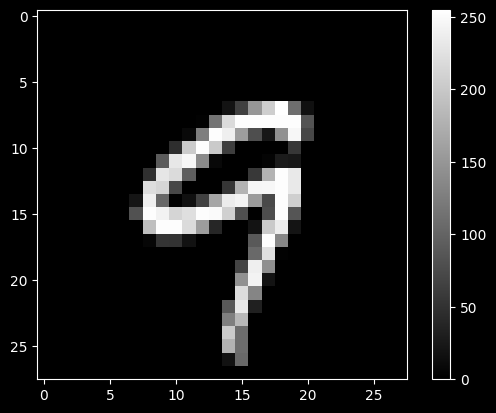

In [50]:
# plot random digit in the training data set
plot_single_digit(data_train[randrange(60000)])

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


### 4. Extracting features from the digit-images using Histogram of Oriented Digits (HOG)

In [51]:
# Function for extracting HOG features from image data
def extract_HOG_features_from_image_data(input_data):
    df_features = pd.DataFrame()
    data_to_be_transformed = input_data
    for image_index in range(data_to_be_transformed.shape[0]):
        fd, hog_image = hog(data_to_be_transformed[image_index], orientations=8, pixels_per_cell=(4, 4),
                        cells_per_block=(1, 1), channel_axis=-1, visualize=True, )   # channel_axis=-1

        if df_features.shape[0] > 0:
            df_features = pd.concat([df_features, pd.DataFrame(hog_image.ravel().T)], ignore_index=True, axis=1)
        else:
            df_features = pd.DataFrame(hog_image.ravel().T)
            
        if (image_index > 0) and (image_index%10000 < 1):
            print("10000 images processed...")

    return pd.DataFrame(df_features.T)


In [52]:
data_train.shape, np.shape(labels_train)

((60000, 28, 28, 1), (60000, 1))

In [53]:
print(data_train[:50, :, :, :].shape)
X_train = extract_HOG_features_from_image_data(data_train[:50, :, :, :])
print(X_train.shape)

(50, 28, 28, 1)
(50, 784)


In [54]:
# Extract (HOG) features from the image data (grab a coffee! This might take a while if you are not on a powerful machine) TODO: Save these as new datafiles? Yes!

X_train = extract_HOG_features_from_image_data(data_train[:2000, :, :, :])
X_test = extract_HOG_features_from_image_data(data_test[:2000, :, :, :])
y_train = np.array(labels_train[:2000], dtype='i').ravel()
y_test = np.array(labels_test[:2000], dtype='i').ravel()

X_train.shape


(2000, 784)

<div style="background-color:rgb(187, 35, 35); padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


#### TODO 3: I have another idea of feature extraction, how about we just compute the mean (and standard deviation) in intensity in X and Y directions?


In [55]:
### Code here

<div style="background-color:rgb(29, 112, 50); padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


#### PCA reduction for visualization

[0.16762485 0.10783767]


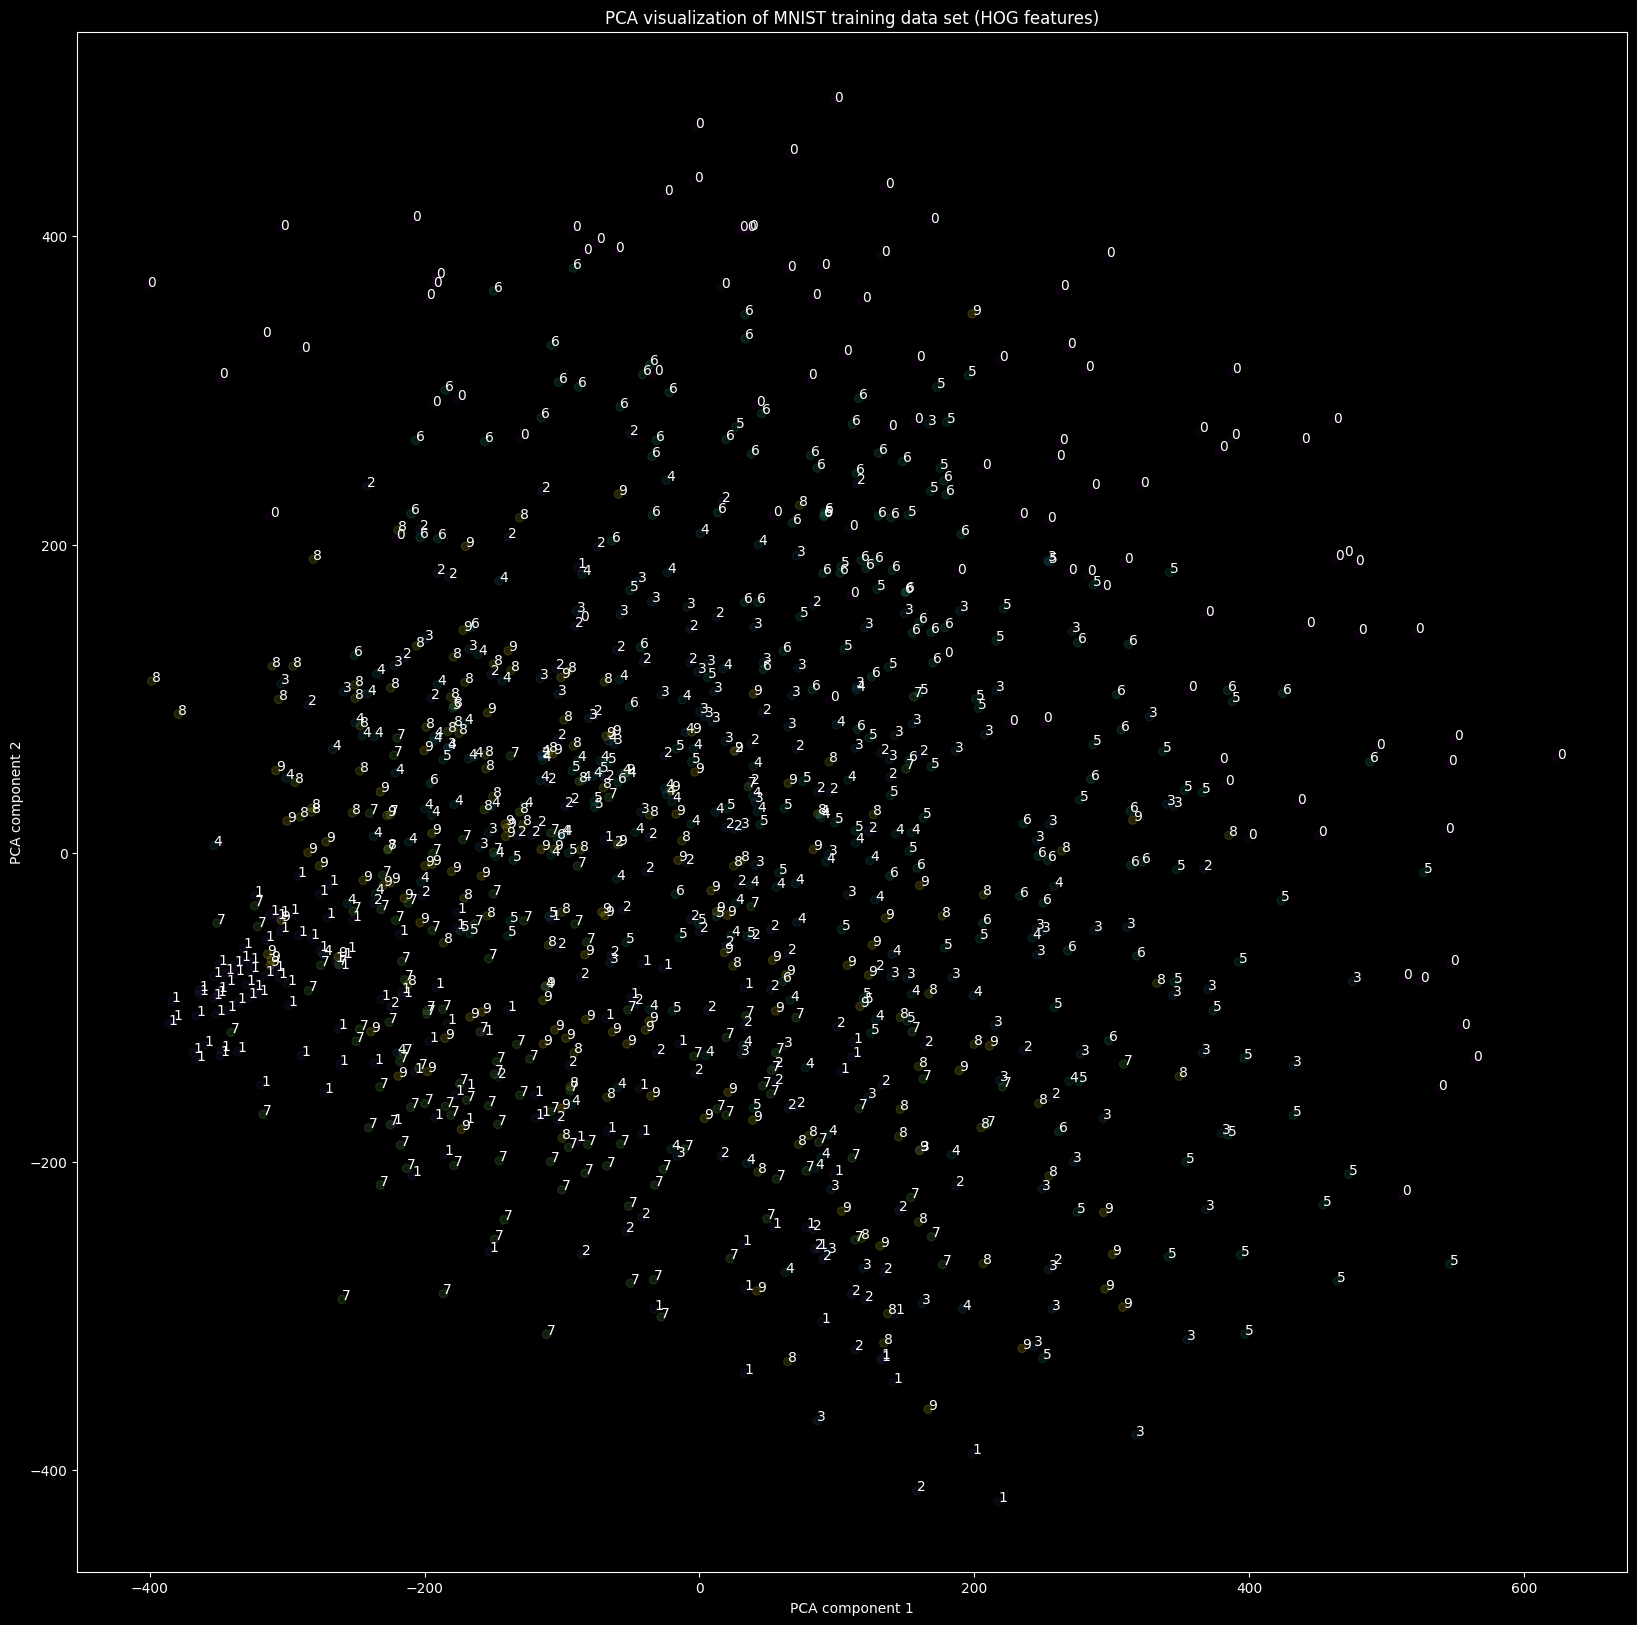

In [56]:
# Visualize (1000 examples of) the extracted features in 2D (reduce the dimensionality of
# the HOG features to 2 by utlizing a method called PCA, will be explained in Module II)

X_for_PCA_viz = X_train[0:1000]
y_for_PCA_viz = y_train[0:1000]

pca = PCA(n_components=2)
X_r = pca.fit(X_for_PCA_viz).transform(X_for_PCA_viz)
print(pca.explained_variance_ratio_)                        # The explained variance of the first two HOG features is extremely low, which contributes to the plots non-interpretability. I see no point in doing this plot what so ever?

plt.figure(figsize=(20, 20))
plt.scatter(X_r[:,0], X_r[:,1], c=y_for_PCA_viz, alpha=0.15)
ax = plt.gca()

for i, the_label in enumerate(y_for_PCA_viz):
    ax.annotate(str(the_label), (X_r[i, 0], X_r[i, 1]))

plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.title("PCA visualization of MNIST training data set (HOG features)")
plt.show()

<div style="background-color:rgb(29, 112, 50); padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


#### Data cleaning through: 
 - Removing uninforamtive features
 - Z-score normalization

In [57]:
def remove_uninformative_features(df_input):
    # if a feature contains only one unique value (it is not informative) then remove it!
    cols = df_input.select_dtypes([np.number]).columns
    std = df_input[cols].std()
    cols_to_drop = std[std==0].index
    df_input = df_input.drop(cols_to_drop, axis=1)
    return df_input, cols_to_drop


def normalize_each_feature(df_input):
    return stats.zscore(df_input)

In [58]:
# check to see if we have uninformative features, if so remove them from the training data set (and drop them from the test set also later)
X_train_with_columns_dropped, columns_that_was_dropped = remove_uninformative_features(X_train)

X_train_normalized = normalize_each_feature(X_train_with_columns_dropped)

X_test_normalized = normalize_each_feature(X_test.drop(columns_that_was_dropped, axis=1))

In [59]:
X_train_with_columns_dropped.shape
X_train_normalized = X_train_normalized.to_numpy(dtype=np.float64)
X_test_normalized = X_test_normalized.to_numpy(dtype=np.float64)

<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


### 6.1 + 8.1 + 9.1. Training and evaluating a kNN model with statistics and plots

<div style="background-color:rgb(187, 35, 35); padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


#### TODO 4: Which digit(s) seems to be the most difficult to predict using the k-NN classifier? Could you use the confusion matrix functions: "plot_confusion_matrix" and visualize and draw conclusions and present to me?

<div style="background-color:rgb(187, 35, 35); padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


#### TODO 5: I'm using 3 neighbours for k-NN, how about we use 5 or 7 neighbours? Would this lead to a better generalization performance? Could you test this? (if so, think about training, validation and test set split)

- Evaluate both approaches with k-fold cross validation on the test set


In [60]:
# Train a model using k-NN (by use of the scikit-learn module)

clf_neigh = KNeighborsClassifier(n_neighbors=7)
clf_neigh.fit(X_train_normalized, y_train)
print("Accuracy of the k-NN model (train) is %2.2f percent " % float(clf_neigh.score(X_train_normalized, y_train)*100.0))
print("Accuracy of the k-NN model (test) is %2.2f percent" % float(clf_neigh.score(X_test_normalized, y_test)*100.0))

predictlable = clf_neigh.predict(X_test_normalized)
print()
cm = confusion_matrix(predictlable,y_test)              ### make a better confusion matrix plot here
print(cm)

Accuracy of the k-NN model (train) is 90.55 percent 
Accuracy of the k-NN model (test) is 82.75 percent

[[170   0  10   1   5   5  17   0  13   1]
 [  1 234  19   7   6   4   4  16  10   0]
 [  0   0 158   2   5   2   3   2   3   1]
 [  0   0   6 171   1  21   0   1   8   1]
 [  0   0   2   3 178   8   3   3   8   7]
 [  0   0   0   3   1 121   1   1   3   3]
 [  3   0   3   2   4   3 150   0   2   0]
 [  0   0  11   8   4   2   0 165   4   3]
 [  1   0   9   8   1   9   0   0 130   0]
 [  0   0   1   2  12   4   0  17  11 178]]


<div style="background-color: #33a2ff; padding: 15px; border-radius: 5px; border: 1px solid #dcdcdc;">


### 6.2 + 8.2 + 9.2. Training and evaluating a linear Support Vector Machines model with statistics and plots.

In [61]:
# Train a model using a Linear Support Vector algorithm (by use of the scikit-learn module)

clf_SVC = LinearSVC(random_state=0, tol=1e-5, max_iter=3000)
clf_SVC.fit(X_train_normalized, y_train)

#....continue here?


LinearSVC(max_iter=3000, random_state=0, tol=1e-05)